In [1]:
# Cell 1
import os
import sys
import torch
import torch.nn.functional as F
import numpy as np
from pathlib import Path

# 프로젝트 루트 경로 추가 (Jupyter 안전)
try:
    PROJECT_ROOT = Path(__file__).resolve().parents[1]
except NameError:
    PROJECT_ROOT = Path.cwd()
    # notebooks/에서 열렸다면 상위로 이동하여 `src` 탐색
    if not (PROJECT_ROOT / 'src').exists():
        if (PROJECT_ROOT.parent / 'src').exists():
            PROJECT_ROOT = PROJECT_ROOT.parent
        elif (PROJECT_ROOT.parent.parent / 'src').exists():
            PROJECT_ROOT = PROJECT_ROOT.parent.parent
sys.path.insert(0, str(PROJECT_ROOT))
print('PROJECT_ROOT =', PROJECT_ROOT)
# 작업 디렉토리를 프로젝트 루트로 강제 설정 (경로 혼동 방지)
import os as _os
try:
    _os.chdir(str(PROJECT_ROOT))
    print('CWD =', Path.cwd())
except Exception as _e:
    print('chdir failed:', _e)

from src.continual_trainer import ContinualTrainer
from src.data_loader import create_domain_dataloaders
from src.utils import normalize_signal, create_windowed_signal
from configs.model_config import DATA_CONFIG

# 공통 유틸
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('DEVICE =', DEVICE)

def get_latest_results_dir():
    """results/ 폴더에서 가장 최신 실험 폴더 자동 감지"""
    results_path = PROJECT_ROOT / 'results'
    if not results_path.exists():
        return None
    
    # 날짜시간 형식 폴더만 필터링 (YYYYMMDD_HHMMSS)
    exp_dirs = [d for d in results_path.iterdir() if d.is_dir() and len(d.name) == 15]
    
    if not exp_dirs:
        return None
    
    # 이름 기준 정렬 (최신이 마지막)
    exp_dirs.sort()
    latest = exp_dirs[-1]
    
    print(f"📁 최신 실험 폴더 자동 감지: {latest.name}")
    return f"results/{latest.name}"

def load_trainer(dataset_type: str, results_dir: str, scenario_name: str, checkpoint_name: str):
    """
    Trainer 생성 및 체크포인트 로드
    
    Args:
        dataset_type: 'uos' 
        results_dir: 결과 디렉토리 (예: 'results/20251013_133656')
        scenario_name: 시나리오 이름 (예: 'UOS_Scenario1_VaryingSpeed')
        checkpoint_name: 체크포인트 파일명 (예: 'domain_800_best.pth')
    """
    results_dir_abs = str((PROJECT_ROOT / results_dir).resolve()) if not os.path.isabs(results_dir) else results_dir
    ckpt_path = os.path.join(results_dir_abs, 'checkpoints', scenario_name, checkpoint_name)
    
    data_dir_abs = str((PROJECT_ROOT / 'data_scenario1').resolve())
    
    # Trainer 생성 (UOS만 지원) - save_dir을 None으로 설정하여 체크포인트 저장 방지
    trainer = ContinualTrainer(
        device=DEVICE,
        save_dir=None,  # 체크포인트 저장하지 않음
        domain_order=[600,800,1000,1200,1400,1600],
        data_dir=data_dir_abs,
        dataset_type=dataset_type
    )
    
    # 🎯 체크포인트 로드
    if os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path, map_location=DEVICE)
        trainer.model.load_state_dict(checkpoint['model_state_dict'])
        trainer.model.eval()
        print(f"✅ 체크포인트 로드 성공: {ckpt_path}")
    else:
        print(f"⚠️  체크포인트 없음: {ckpt_path}")
        print(f"   랜덤 초기화 모델 사용 (정확도 낮을 것)")
    
    print(f"Checkpoint path: {ckpt_path}")
    print(f"Data dir: {data_dir_abs}")
    return trainer, ckpt_path




PROJECT_ROOT = /data/home/kyj2024/TextVibCLIP
CWD = /data/home/kyj2024/TextVibCLIP


/data/home/kyj2024/anaconda3/envs/TVCLIP/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/home/kyj2024/anaconda3/envs/TVCLIP/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/data/home/kyj2024/anaconda3/envs/TVCLIP

DEVICE = cuda


In [2]:
# Cell 2 - 통합 시각화 함수
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# UOS 7-클래스 색상 팔레트
COLORS7 = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2']

def visualize_retrieval(results_dir: str,
                        sample_number: int,
                        domain_rpm: int = 600,
                        subset: str = 'test',
                        scenario: str = 'UOS_Scenario1_VaryingSpeed',
                        save_path: str = None):
    """
    UOS 실험 결과에서 특정 샘플의 cosine similarity 시각화 (통합 함수)
    
    Args:
        results_dir: 실험 결과 디렉토리 (예: 'results/20251016_155531')
        sample_number: 시각화할 샘플 번호 (0부터 시작)
        domain_rpm: 도메인 RPM (600, 800, 1000, 1200, 1400, 1600)
        subset: 데이터 서브셋 ('test' 또는 'val')
        scenario: 시나리오 이름
        save_path: 저장 경로 (옵션)
    """
    print(f"🔍 UOS Cosine Similarity Visualization")
    print(f"   Results dir: {results_dir}")
    print(f"   Sample number: {sample_number}")
    print(f"   Domain: {domain_rpm}RPM")
    print(f"   Subset: {subset}")
    print(f"   Scenario: {scenario}")
    print()
    
    # 체크포인트 파일명 결정
    if domain_rpm == 600:
        checkpoint = 'first_domain_final.pth'
    else:
        checkpoint = f'domain_{domain_rpm}_best.pth'
    
    # Trainer 로드
    trainer, ckpt_path = load_trainer('uos', results_dir, scenario, checkpoint)
    
    # 도메인별 dataloader 준비
    loaders = create_domain_dataloaders(
        data_dir='data_scenario1', 
        domain_order=[600,800,1000,1200,1400,1600], 
        dataset_type='uos', 
        batch_size=64
    )
    loader = loaders[domain_rpm][subset]
    
    # 샘플 선택
    dataset = loader.dataset
    print(f"📁 Dataset: UOS {domain_rpm}RPM ({subset}) - {len(dataset)} samples")
    
    if sample_number >= len(dataset):
        print(f"⚠️  Sample number {sample_number} is out of range [0, {len(dataset)-1}]")
        sample_number = sample_number % len(dataset)
        print(f"   Adjusted to: {sample_number}")
    
    sample = dataset[sample_number]
    
    vib = sample['vibration'].unsqueeze(0).to(DEVICE)
    labels_uos = sample['labels'].unsqueeze(0)  # [1,2] 구조
    
    # UOS 7-클래스 텍스트 프롬프트
    prompt_bank = {
        0: ["healthy bearing"],          # H_H
        1: ["bearing with ball fault"],  # H_B
        2: ["inner race fault"],         # H_IR
        3: ["outer race fault"],         # H_OR
        4: ["mechanical looseness"],     # L_H
        5: ["rotor unbalance"],          # U_H
        6: ["shaft misalignment"],       # M_H
    }
    
    # 텍스트 프로토타입 생성 및 추론
    trainer.model.eval()
    with torch.no_grad():
        # 진동 신호 임베딩
        vib_raw = trainer.model.vib_encoder(vib)
        vib_emb = F.normalize(trainer.model.vib_projection(vib_raw), p=2, dim=1)
        
        # 텍스트 프로토타입 임베딩
        proto = []
        for cls_id in [0,1,2,3,4,5,6]:
            raw = trainer.model.text_encoder.encode_texts(prompt_bank[cls_id], DEVICE)
            proj = F.normalize(trainer.model.text_projection(raw), p=2, dim=1)
            proto.append(F.normalize(proj.mean(dim=0, keepdim=True), p=2, dim=1))
        proto_mat = torch.cat(proto, dim=0)
        
        # Cosine similarity 계산
        sims = vib_emb @ proto_mat.t()
        pred = sims.argmax(dim=1).item()
    
    # 클래스 이름
    prompts7 = [
        "Healthy Bearing", "Ball Fault", "Inner Race Fault", "Outer Race Fault",
        "Mechanical Looseness", "Rotor Unbalance", "Shaft Misalignment"
    ]
    
    # Ground truth 라벨 추출
    try:
        gt_idx = int(labels_uos[0, 0].item())
        gt_text = prompts7[gt_idx] if 0 <= gt_idx < len(prompts7) else None
    except Exception:
        gt_text = None
    
    print(f"🎯 Prediction: {prompts7[pred]} (label {pred})")
    if gt_text:
        print(f"🏷️  Ground Truth: {gt_text} (label {gt_idx})")
        print(f"✅ Correct: {'Yes' if pred == gt_idx else 'No'}")
    print()
    
    # 시각화
    _plot_retrieval_result(
        vib_signal=vib,
        prompts=prompts7,
        sims=sims,
        pred_idx=pred,
        title=f"UOS {domain_rpm}RPM ({subset})",
        true_label=gt_text,
        sample_index=sample_number,
        save_path=save_path
    )

def _plot_retrieval_result(vib_signal: torch.Tensor,
                          prompts: list,
                          sims: torch.Tensor,
                          pred_idx: int,
                          title: str = 'Retrieval Result',
                          true_label: str = None,
                          sample_index: int = None,
                          save_path: str = None):
    """
    분리된 플롯으로 출력 - 각각 독립적인 figure
    """
    vib_np = vib_signal.detach().cpu().numpy().reshape(-1)
    sims_np = sims.detach().cpu().numpy().reshape(-1)
    num_classes = len(prompts)
    colors = COLORS7[:num_classes]

    # 1. 진동신호 플롯
    plt.figure(figsize=(10, 4))
    plt.plot(vib_np, color='#34495e', linewidth=1.2)
    plt.title('Vibration Signal', fontweight='bold', fontsize=14)
    plt.xlabel('Data Point', fontsize=12)
    plt.ylabel('Amplitude', fontsize=12)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

    # 2. 정보 패널 플롯 (표 형태)
    plt.figure(figsize=(8, 4))
    ax_info = plt.gca()
    ax_info.axis('off')
    
    # 도메인 정보
    domain_info = title.split()[1] if len(title.split()) > 1 else "Unknown"
    ax_info.text(0.05, 0.95, f"Domain: {domain_info}", transform=ax_info.transAxes, 
                fontsize=14, verticalalignment='top', fontweight='bold', color='#333333')
    
    if sample_index is not None:
        ax_info.text(0.05, 0.85, f"Sample: #{sample_index}", transform=ax_info.transAxes, 
                    fontsize=14, verticalalignment='top', fontweight='bold', color='#333333')
    
    # 표 형태
    header_y = 0.75
    ax_info.text(0.05, header_y, "Category", transform=ax_info.transAxes, 
                fontsize=13, verticalalignment='top', fontweight='bold', color='#333333')
    ax_info.text(0.3, header_y, "Prediction", transform=ax_info.transAxes, 
                fontsize=13, verticalalignment='top', fontweight='bold', color='#333333')
    if true_label is not None:
        ax_info.text(0.6, header_y, "Ground Truth", transform=ax_info.transAxes, 
                    fontsize=13, verticalalignment='top', fontweight='bold', color='#333333')
    
    # 구분선
    line_y = header_y - 0.04
    ax_info.plot([0.05, 0.95], [line_y, line_y], transform=ax_info.transAxes, 
                color='#666666', linewidth=2, alpha=0.8)
    
    # 표 내용
    content_y = header_y - 0.08
    ax_info.text(0.05, content_y, "Class", transform=ax_info.transAxes, 
                fontsize=12, verticalalignment='top', fontweight='normal', color='#333333')
    ax_info.text(0.3, content_y, prompts[pred_idx], transform=ax_info.transAxes, 
                fontsize=12, verticalalignment='top', fontweight='normal', color='#333333')
    if true_label is not None:
        ax_info.text(0.6, content_y, true_label, transform=ax_info.transAxes, 
                    fontsize=12, verticalalignment='top', fontweight='normal', color='#333333')
    
    # Confidence 행
    conf_y = content_y - 0.06
    ax_info.text(0.05, conf_y, "Confidence", transform=ax_info.transAxes, 
                fontsize=12, verticalalignment='top', fontweight='normal', color='#333333')
    ax_info.text(0.3, conf_y, f"{sims_np[pred_idx]:.3f}", transform=ax_info.transAxes, 
                fontsize=12, verticalalignment='top', fontweight='normal', color='#333333')
    if true_label is not None:
        is_correct = prompts[pred_idx] == true_label
        status_text = "✓ Correct" if is_correct else "✗ Incorrect"
        status_color = "#28a745" if is_correct else "#dc3545"
        ax_info.text(0.6, conf_y, status_text, transform=ax_info.transAxes, 
                    fontsize=12, verticalalignment='top', fontweight='normal', color=status_color)
    
    plt.tight_layout()
    plt.show()

    # 3. Cosine similarity bar chart
    plt.figure(figsize=(12, 6))
    x = np.arange(num_classes)
    bars = plt.bar(x, sims_np, color=colors, alpha=0.8, edgecolor='white', linewidth=1.0)
    
    # 예측된 클래스 강조
    bars[pred_idx].set_edgecolor('#d62728')
    bars[pred_idx].set_linewidth(3)
    
    # y=0 기준선
    plt.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.7)
    
    # 라벨 처리
    label_texts = []
    for p in prompts:
        words = p.split()
        if len(words) == 3:
            label_texts.append(f"{words[0]}\n{' '.join(words[1:])}")
        elif len(words) == 2:
            label_texts.append(f"{words[0]}\n{words[1]}")
        else:
            label_texts.append(p)
    
    plt.xticks(x, label_texts, rotation=0, ha='center', fontsize=12, fontweight='bold')
    plt.title('Cosine Similarity', fontweight='bold', fontsize=14)
    plt.ylabel('Similarity', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # y-limit 설정
    maxy = float(sims_np.max()) if sims_np.size > 0 else 1.0
    miny = float(sims_np.min()) if sims_np.size > 0 else 0.0
    
    if miny >= 0:
        ylim_top = max(maxy * 1.25, maxy + 0.02)
        ylim_top = max(0.2, ylim_top)
        plt.ylim(0, ylim_top)
    else:
        ylim_top = max(maxy * 1.15, maxy + 0.05)
        ylim_bottom = min(miny * 1.15, miny - 0.05)
        plt.ylim(ylim_bottom, ylim_top)
    
    # 값 표시
    ylim_bottom, ylim_top = plt.ylim()
    y_range = ylim_top - ylim_bottom
    
    for i, (b, val) in enumerate(zip(bars, sims_np)):
        if val >= 0:
            text_y = b.get_height() + y_range * 0.02
            va = 'bottom'
        else:
            text_y = b.get_height() - y_range * 0.02
            va = 'top'
        
        plt.text(b.get_x() + b.get_width()/2, text_y, 
                f"{val:.3f}", ha='center', va=va, fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9))
    
    plt.tight_layout()
    plt.show()



🔍 UOS Cosine Similarity Visualization
   Results dir: results/20251016_155531
   Sample number: 100
   Domain: 600RPM
   Subset: test
   Scenario: UOS_Scenario1_VaryingSpeed

✅ 체크포인트 로드 성공: /data/home/kyj2024/TextVibCLIP/results/20251016_155531/checkpoints/UOS_Scenario1_VaryingSpeed/first_domain_final.pth
Checkpoint path: /data/home/kyj2024/TextVibCLIP/results/20251016_155531/checkpoints/UOS_Scenario1_VaryingSpeed/first_domain_final.pth
Data dir: /data/home/kyj2024/TextVibCLIP/data_scenario1
📁 Dataset: UOS 600RPM (test) - 1169 samples
🎯 Prediction: Rotor Unbalance (label 5)
🏷️  Ground Truth: Rotor Unbalance (label 5)
✅ Correct: Yes



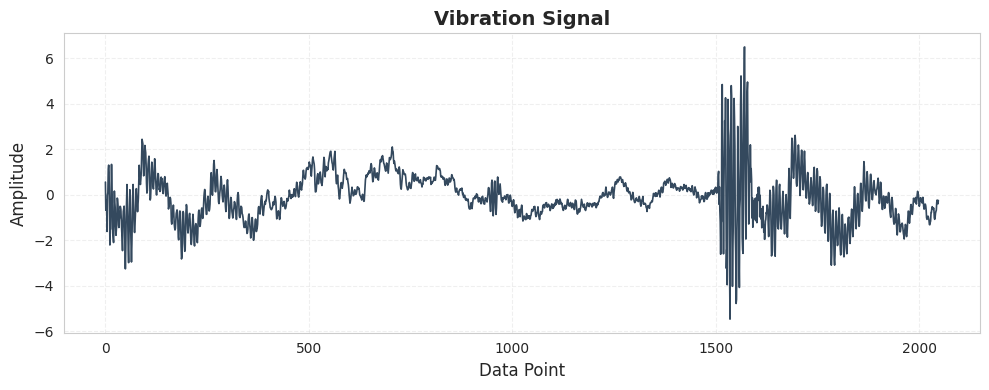

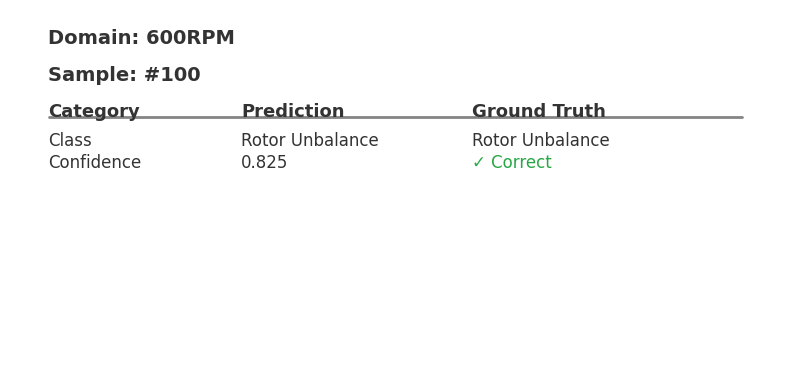

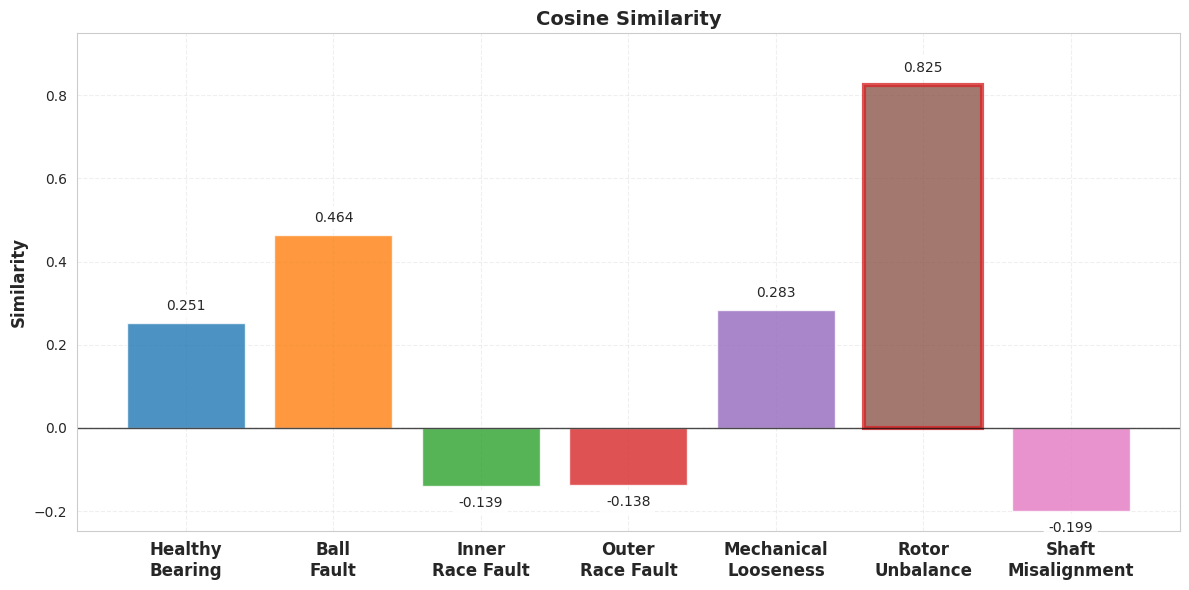

In [3]:
# Cell 4 - 정보패널 표 형태로 가독성 개선
visualize_retrieval(
    results_dir='results/20251016_155531',
    sample_number=100,
    domain_rpm=600,
    subset='test'
)


🔍 UOS Cosine Similarity Visualization
   Results dir: results/20251016_155531
   Sample number: 100
   Domain: 800RPM
   Subset: test
   Scenario: UOS_Scenario1_VaryingSpeed

✅ 체크포인트 로드 성공: /data/home/kyj2024/TextVibCLIP/results/20251016_155531/checkpoints/UOS_Scenario1_VaryingSpeed/domain_800_best.pth
Checkpoint path: /data/home/kyj2024/TextVibCLIP/results/20251016_155531/checkpoints/UOS_Scenario1_VaryingSpeed/domain_800_best.pth
Data dir: /data/home/kyj2024/TextVibCLIP/data_scenario1
📁 Dataset: UOS 800RPM (test) - 1169 samples
🎯 Prediction: Rotor Unbalance (label 5)
🏷️  Ground Truth: Rotor Unbalance (label 5)
✅ Correct: Yes



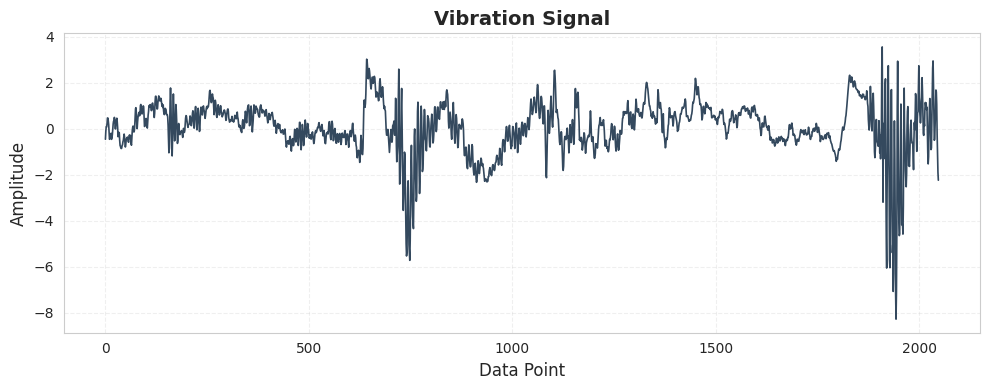

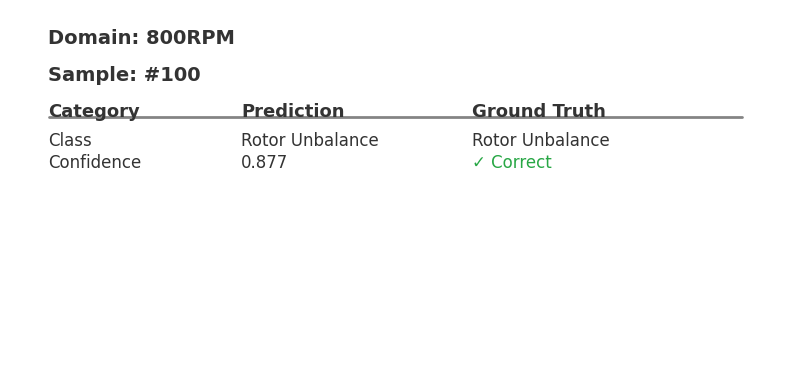

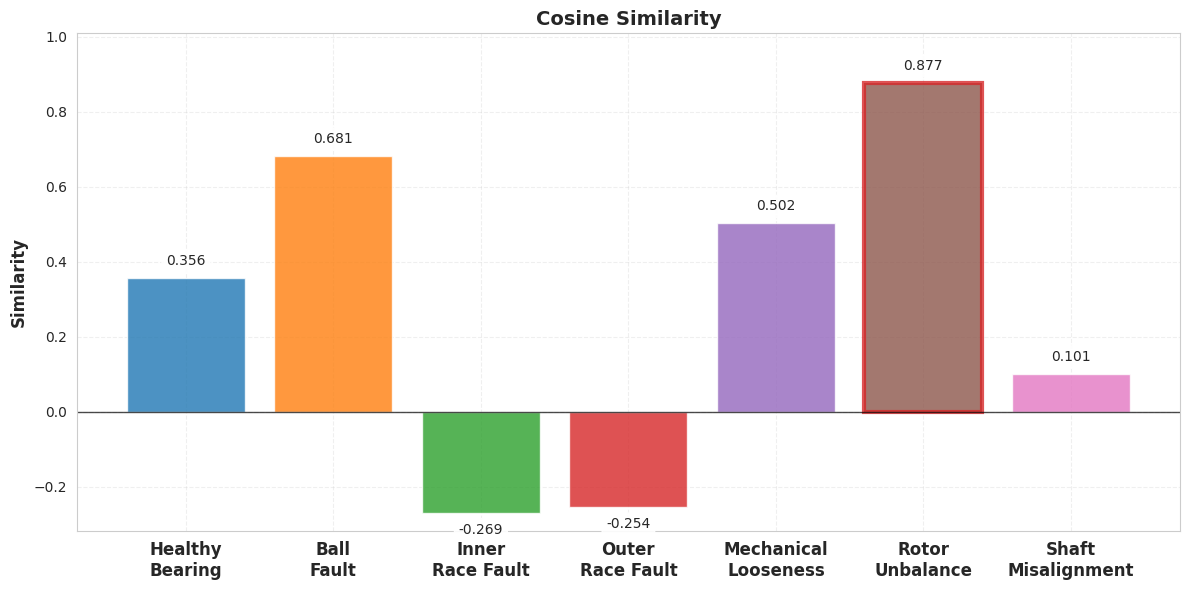

In [4]:
# Cell 5 - 예제 2: 다른 도메인 (800RPM)
visualize_retrieval(
    results_dir='results/20251016_155531',
    sample_number=100,
    domain_rpm=800,
    subset='test'
)


🔍 UOS Cosine Similarity Visualization
   Results dir: results/20251016_155531
   Sample number: 500
   Domain: 600RPM
   Subset: test
   Scenario: UOS_Scenario1_VaryingSpeed

✅ 체크포인트 로드 성공: /data/home/kyj2024/TextVibCLIP/results/20251016_155531/checkpoints/UOS_Scenario1_VaryingSpeed/first_domain_final.pth
Checkpoint path: /data/home/kyj2024/TextVibCLIP/results/20251016_155531/checkpoints/UOS_Scenario1_VaryingSpeed/first_domain_final.pth
Data dir: /data/home/kyj2024/TextVibCLIP/data_scenario1
📁 Dataset: UOS 600RPM (test) - 1169 samples
🎯 Prediction: Shaft Misalignment (label 6)
🏷️  Ground Truth: Shaft Misalignment (label 6)
✅ Correct: Yes



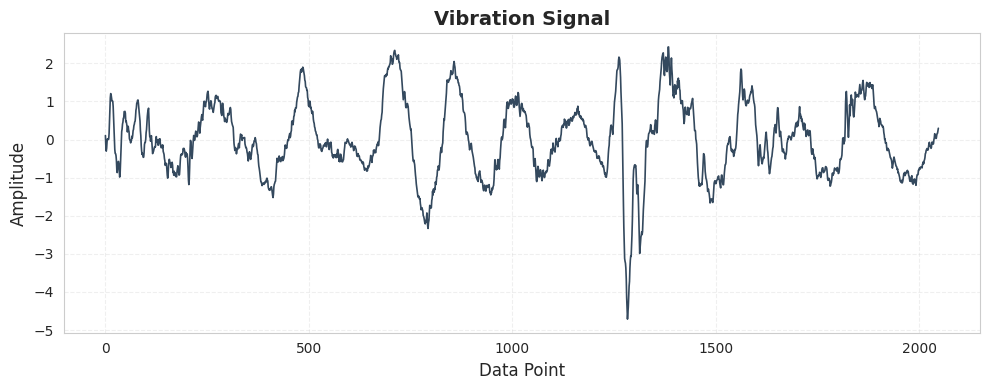

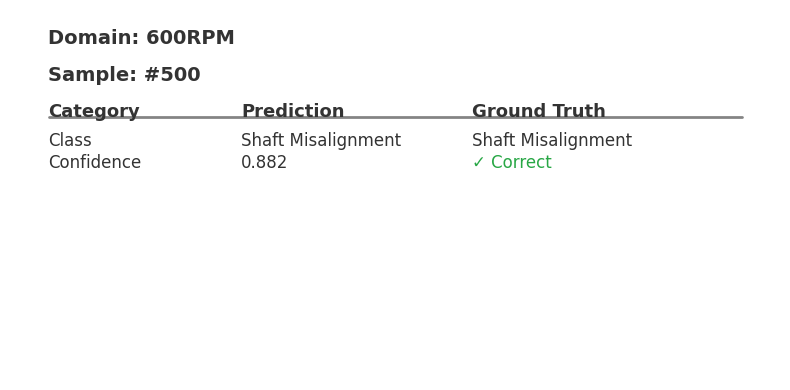

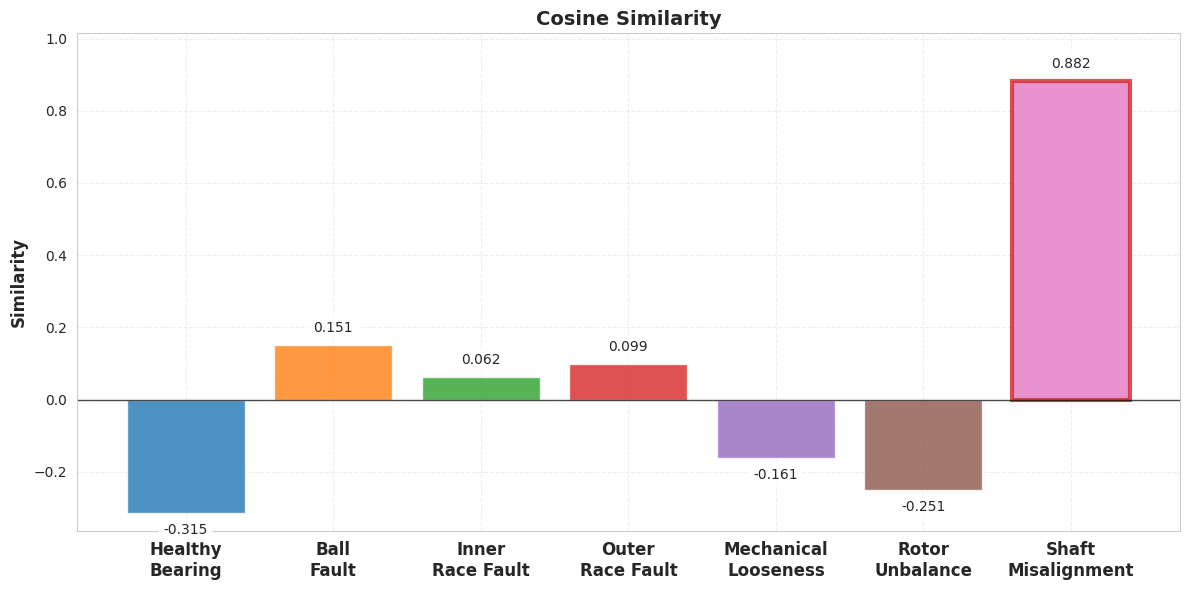

In [5]:
# Cell 6 - 예제 3: 다른 샘플 번호
visualize_retrieval(
    results_dir='results/20251016_155531',
    sample_number=500,
    domain_rpm=600,
    subset='test'
)
